In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# prepro test 1
data_path = '../data/curated/2016_12_sc.parquet'
df = pd.read_parquet(data_path)
date1 = f"2016-12-01 00:00:00"
date2 = f"2016-12-30 23:59:59"
df = df[(df["tpep_pickup_datetime"] >= date1) & (df["tpep_pickup_datetime"] <= date2)]
df = df[df.trip_distance > 0]
df = df[(df['payment_type'] == 1) | (df['payment_type'] == 2)]
# remove all data that does not follow normal payment trend (i.e. lower than basic fare amount or negative tip amount)
removed_df = df[(df.fare_amount >= 2.5) & (df.tip_amount >= 0)]
# Filling tips amounts for credit cash payment
### calculate average percentage of tip amount 
card_pmt = removed_df.loc[removed_df['payment_type'] == 1, ['tip_amount','total_amount']]
tip_rate = (card_pmt.tip_amount/card_pmt.total_amount).mean()
removed_df.loc[removed_df['payment_type'] == 2, 'tip_amount'] = removed_df['total_amount'] * tip_rate
removed_df['cashtip'] = removed_df['tip_amount'] * (removed_df['payment_type']-1)
removed_df['total_adjusted_amount'] = removed_df['cashtip']+ removed_df['total_amount']
removed_df = removed_df.drop(['cashtip'], axis=1)
# Calculatae income_rate as response variable
removed_df['income_rate'] = (removed_df['total_adjusted_amount']-2.5) / removed_df['trip_distance']


/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


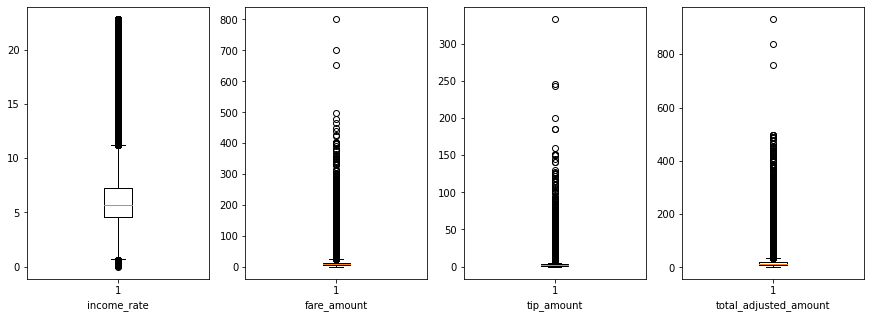

In [4]:
# Removing income rate outliers by 1.5IQR
cols = ['income_rate']
Q0 = removed_df[cols].quantile(0.05)
Q1 = removed_df[cols].quantile(0.25)
Q3 = removed_df[cols].quantile(0.75)
Q4 = removed_df[cols].quantile(0.95)
IQR = Q4 - Q0
removed_df = removed_df[((removed_df[cols] >= (Q0 - 1.5 * IQR)) & (removed_df[cols] <= (Q4 + 1.5 * IQR))).all(axis=1)]
# boxplot of three numerical values
cols = ['income_rate', 'fare_amount', 'tip_amount','total_adjusted_amount']
fig, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
    axs[i].boxplot(removed_df[cols[i]])
    axs[i].set_xlabel(cols[i])
plt.show()

In [ ]:
# Removing income rate outliers by 1.5IQR
cols = ['income_rate']
Q1 = removed_df['income_rate'].quantile(0.25)
Q3 = removed_df['income_rate'].quantile(0.75)
IQR = Q3 - Q1
removed_df = removed_df[((removed_df[cols] >= (Q1 - 1.5 * IQR)) & (removed_df[cols] <= (Q3 + 1.5 * IQR))).all(axis=1)]
after_prep_df = removed_df[['PULocationID','DOLocationID','tpep_pickup_datetime','tpep_dropoff_datetime','total_adjusted_amount','income_rate']]
date = after_prep_df['tpep_pickup_datetime'].dt.date
after_prep_df["date"] = date        
agg_df = after_prep_df.groupby(['PULocationID','date']).agg({'PULocationID':'first','income_rate':'mean','total_adjusted_amount':'mean'})
agg_df = agg_df.drop(['PULocationID'], axis=1)
agg_df = agg_df.reset_index()
agg_df.to_csv('../data/curated/'+'cleaned_data.csv', index = False)


In [3]:
import calendar
import datetime
for year in range(2017, 2018+1):
    for month in [1, 2, 11, 12]:
        data_path = '../data/curated/' + str(year) + '_' + str(month) + '_sc.parquet'
        df = pd.read_parquet(data_path)
        date1 = datetime.datetime(year=year, month=month, day=1)
        date2 = datetime.datetime(year=year, month=month, day=calendar.monthrange(year, month)[1],hour = 23, minute = 59, second = 59)
        
        df = df[(df["tpep_pickup_datetime"] >= date1) & (df["tpep_pickup_datetime"] <= date2)]
        df = df[df.trip_distance > 0]
        df = df[(df['payment_type'] == 1) | (df['payment_type'] == 2)]
        # remove all data that does not follow normal payment trend (i.e. lower than basic fare amount or negative tip amount)
        removed_df = df[(df.fare_amount >= 2.5) & (df.tip_amount >= 0)]
        # Filling tips amounts for credit cash payment
        ### calculate average percentage of tip amount 
        card_pmt = removed_df.loc[removed_df['payment_type'] == 1, ['tip_amount','total_amount']]
        tip_rate = (card_pmt.tip_amount/card_pmt.total_amount).mean()
        removed_df.loc[removed_df['payment_type'] == 2, 'tip_amount'] = removed_df['total_amount'] * tip_rate
        removed_df['cashtip'] = removed_df['tip_amount'] * (removed_df['payment_type']-1)
        removed_df['total_adjusted_amount'] = removed_df['cashtip']+ removed_df['total_amount']
        removed_df = removed_df.drop(['cashtip'], axis=1)
        # Calculatae income_rate as response variable
        removed_df['income_rate'] = (removed_df['total_adjusted_amount']-2.5) / removed_df['trip_distance']
        # Removing income rate outliers by 1.5IQR
        cols = ['income_rate']
        Q1 = removed_df['income_rate'].quantile(0.25)
        Q3 = removed_df['income_rate'].quantile(0.75)
        IQR = Q3 - Q1
        removed_df = removed_df[((removed_df[cols] >= (Q1 - 1.5 * IQR)) & (removed_df[cols] <= (Q3 + 1.5 * IQR))).all(axis=1)]
        after_prep_df = removed_df[['PULocationID','DOLocationID','tpep_pickup_datetime','tpep_dropoff_datetime','total_adjusted_amount','income_rate']]
        date = after_prep_df['tpep_pickup_datetime'].dt.date
        after_prep_df["date"] = date        
        agg_df = after_prep_df.groupby(['PULocationID','date']).agg({'PULocationID':'first','income_rate':'mean','total_adjusted_amount':'mean'})
        agg_df = agg_df.drop(['PULocationID'], axis=1)
        agg_df = agg_df.reset_index()
        agg_df.to_csv('../data/curated/cleaned_data.csv', mode = 'a',header = False, index = False)
        

In [4]:
for year in range(2017, 2018+1):
    for month in [1, 2, 11, 12]:
        print('../data/curated/' + str(year) + '_' + str(month) + '_sc.parquet')

../data/curated/2017_1_sc.parquet
../data/curated/2017_2_sc.parquet
../data/curated/2017_11_sc.parquet
../data/curated/2017_12_sc.parquet
../data/curated/2018_1_sc.parquet
../data/curated/2018_2_sc.parquet
../data/curated/2018_11_sc.parquet
../data/curated/2018_12_sc.parquet
